In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'pandas'

In [2]:
from pycaret.classification import *

In [3]:
def write_submission(date, pred, output_file):
    """予測結果を出力します."""
    df = pd.DataFrame({'Datetime': date, 'y': pred})
    df.to_csv(output_file, index=False, header=False)

In [4]:
import csv

# TSVファイルのパス
tsv_file = 'train.tsv'

# CSVファイルのパス
csv_file = 'train.csv'

# TSVファイルをCSVファイルに変換する
with open(tsv_file, 'r', newline='', encoding='utf-8') as tsv_infile:
    with open(csv_file, 'w', newline='', encoding='utf-8') as csv_outfile:
        tsv_reader = csv.reader(tsv_infile, delimiter='\t')
        csv_writer = csv.writer(csv_outfile, dialect='excel')
        
        # 各行を読み取り、CSVファイルに書き込む
        for row in tsv_reader:
            csv_writer.writerow(row)

In [5]:
import csv

# TSVファイルのパス
tsv_file = 'test.tsv'

# CSVファイルのパス
csv_file = 'test.csv'

# TSVファイルをCSVファイルに変換する
with open(tsv_file, 'r', newline='', encoding='utf-8') as tsv_infile:
    with open(csv_file, 'w', newline='', encoding='utf-8') as csv_outfile:
        tsv_reader = csv.reader(tsv_infile, delimiter='\t')
        csv_writer = csv.writer(csv_outfile, dialect='excel')
        
        # 各行を読み取り、CSVファイルに書き込む
        for row in tsv_reader:
            csv_writer.writerow(row)

print(f'{tsv_file} を {csv_file} に変換しました。')

test.tsv を test.csv に変換しました。


In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
train_df

,Unnamed: 0,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,1.51720,13.38,3.50,1.15,72.85,0.50,8.43,0.0,0.00,1
1,1,1.51631,13.34,3.57,1.57,72.87,0.61,7.89,0.0,0.00,2
2,3,1.52043,13.38,0.00,1.40,72.25,0.33,12.50,0.0,0.00,5
3,6,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,1
4,9,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.0,0.03,1
...,...,...,...,...,...,...,...,...,...,...,...
102,206,1.52210,13.73,3.84,0.72,71.76,0.17,9.74,0.0,0.00,1
103,207,1.51847,13.10,3.97,1.19,72.44,0.60,8.43,0.0,0.00,2
104,210,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
105,211,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.0,0.00,2


In [8]:
for col in train_df.columns:
    if ' ' in col:
        train_df.rename(columns={col: 'ID'}, inplace=True)
        
for col in test_df.columns:
    if ' ' in col:
        test_df.rename(columns={col: 'ID'}, inplace=True)

In [9]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      107 non-null    int64  
 1   RI      107 non-null    float64
 2   Na      107 non-null    float64
 3   Mg      107 non-null    float64
 4   Al      107 non-null    float64
 5   Si      107 non-null    float64
 6   K       107 non-null    float64
 7   Ca      107 non-null    float64
 8   Ba      107 non-null    float64
 9   Fe      107 non-null    float64
 10  Type    107 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 9.3 KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      107 non-null    int64  
 1   RI      107 non-null    float64
 2   Na      107 non-null    float64
 3   Mg      107 non-null    floa

In [10]:
train_df.describe(include='all')

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,109.943925,1.518351,13.466822,2.840841,1.429159,72.580654,0.462897,8.882710,0.156075,0.054393,2.616822
std,62.111256,0.002959,0.648722,1.345518,0.475688,0.761424,0.312573,1.378218,0.486669,0.089307,1.979350
min,0.000000,1.512150,12.200000,0.000000,0.290000,69.890000,0.000000,5.790000,0.000000,0.000000,1.000000
25%,57.500000,1.516485,12.995000,2.785000,1.175000,72.235000,0.165000,8.160000,0.000000,0.000000,1.000000
50%,105.000000,1.517610,13.380000,3.500000,1.380000,72.760000,0.560000,8.560000,0.000000,0.000000,2.000000
75%,168.000000,1.519355,13.805000,3.595000,1.595000,73.060000,0.620000,9.140000,0.000000,0.100000,2.500000
max,212.000000,1.533930,14.990000,4.490000,3.500000,74.550000,1.680000,16.190000,2.880000,0.320000,7.000000


In [11]:
train_df = train_df.drop({'ID'}, axis=1)
Id = test_df['ID']
train_objective = train_df['Type']
train_features = train_df.drop('Type', axis=1)
test_features = test_df.drop('ID', axis=1)

In [12]:
train_check = pd.concat([train_features, train_objective], axis=1)

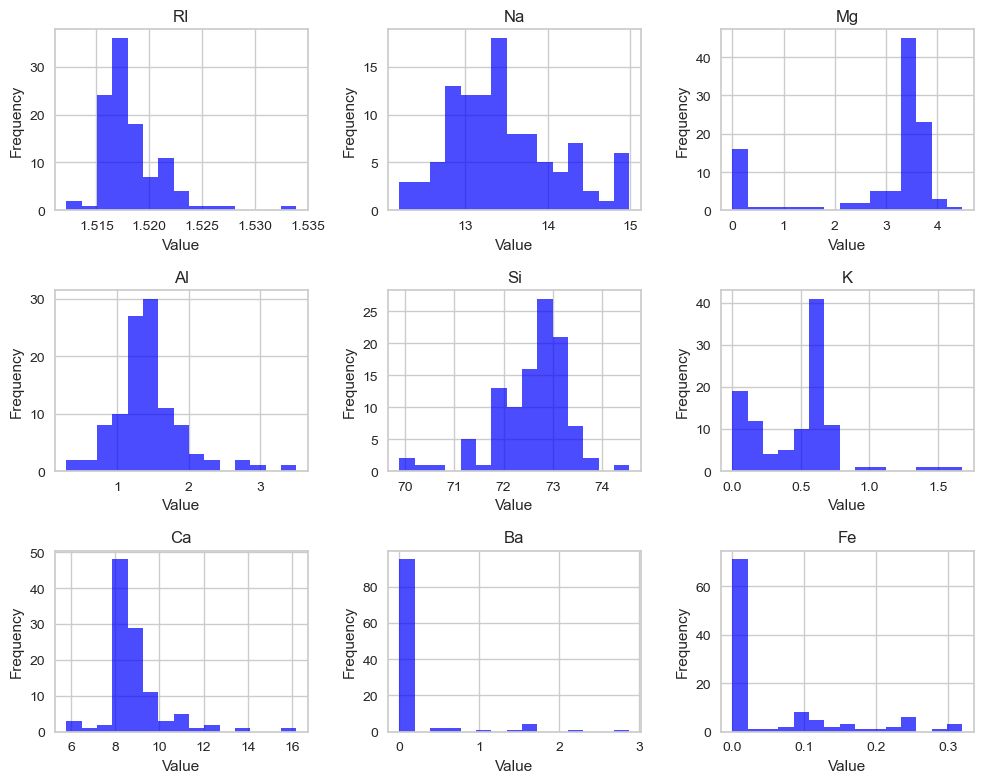

In [13]:
component = [col for col in train_features.columns]
# サブプロットを3x3のグリッドで作成
fig, axes = plt.subplots(3, 3, figsize=(10, 8))

# サブプロットにヒストグラムをプロット
for i, ax in enumerate(axes.flat):
    column_name = component[i]
    column_data = train_features[column_name]
    
    ax.hist(column_data, bins=15, color='blue', alpha=0.7)
    ax.set_title(f'{component[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# サブプロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show()

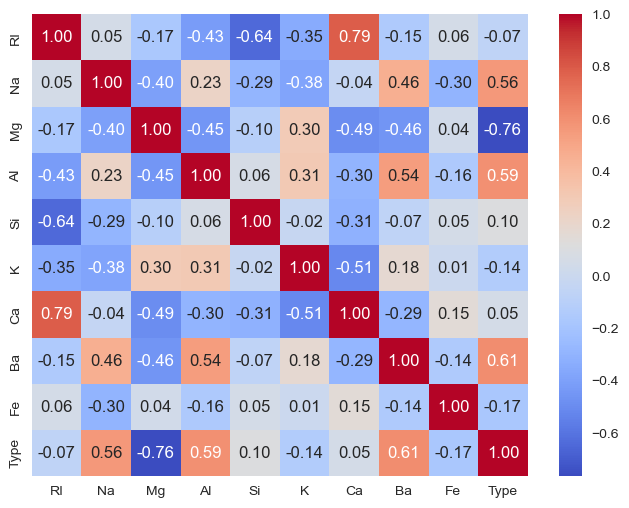

In [14]:
# 相関行列を計算
correlation_matrix = train_check.corr()

# ヒートマップを描画
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# プロットを表示
plt.show()

In [15]:
import itertools
def create_features(df):
    df = df.copy()
    
    elements = ['Na', 'Mg', 'Al', 'Ca']
    pairs = list(itertools.combinations(elements, 2))
    
    for i, j in pairs:
        df[f'Ratio_{i}_{j}'] = df[i]/df[j].replace(0, np.nan)
        
    df.fillna(0, inplace=True)
    
    for element in elements:
        df[f'RI*{element}'] = df['RI']*df[element]
        
    return df

train_features = create_features(train_features)
test_features = create_features(test_features)

In [16]:
col_tr = list(train_features.columns)
col_te = list(test_features.columns)
SS = StandardScaler()
combine_feature = pd.concat([train_features, test_features])
columns_to_standardize = [col for col in combine_feature]
col_combine = list(combine_feature.columns)
combine_feature[columns_to_standardize] = SS.fit(combine_feature[columns_to_standardize])
train_features[columns_to_standardize] = SS.transform(train_features[columns_to_standardize])
test_features[columns_to_standardize] = SS.transform(test_features[columns_to_standardize])
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features.columns = col_tr
test_features.columns = col_te

In [17]:
print(train_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RI           107 non-null    float64
 1   Na           107 non-null    float64
 2   Mg           107 non-null    float64
 3   Al           107 non-null    float64
 4   Si           107 non-null    float64
 5   K            107 non-null    float64
 6   Ca           107 non-null    float64
 7   Ba           107 non-null    float64
 8   Fe           107 non-null    float64
 9   Ratio_Na_Mg  107 non-null    float64
 10  Ratio_Na_Al  107 non-null    float64
 11  Ratio_Na_Ca  107 non-null    float64
 12  Ratio_Mg_Al  107 non-null    float64
 13  Ratio_Mg_Ca  107 non-null    float64
 14  Ratio_Al_Ca  107 non-null    float64
 15  RI*Na        107 non-null    float64
 16  RI*Mg        107 non-null    float64
 17  RI*Al        107 non-null    float64
 18  RI*Ca        107 non-null    float64
dtypes: float

In [18]:
combine = [train_features, test_features]
for d in combine:
    d['first'] = d['K']+d['Na']
    d['second'] = d['Ca']+d['Mg']+d['Ba']+2*d['Fe']/3
    d['third'] = d['Al']+d['Fe']/3

In [19]:
col_tr = list(train_features.columns)
col_te = list(test_features.columns)
SS = StandardScaler()
combine_feature = pd.concat([train_features, test_features])
columns_to_standardize = [col for col in combine_feature]
col_combine = list(combine_feature.columns)
combine_feature[columns_to_standardize] = SS.fit(combine_feature[columns_to_standardize])
train_features[columns_to_standardize] = SS.transform(train_features[columns_to_standardize])
test_features[columns_to_standardize] = SS.transform(test_features[columns_to_standardize])
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features.columns = col_tr
test_features.columns = col_te

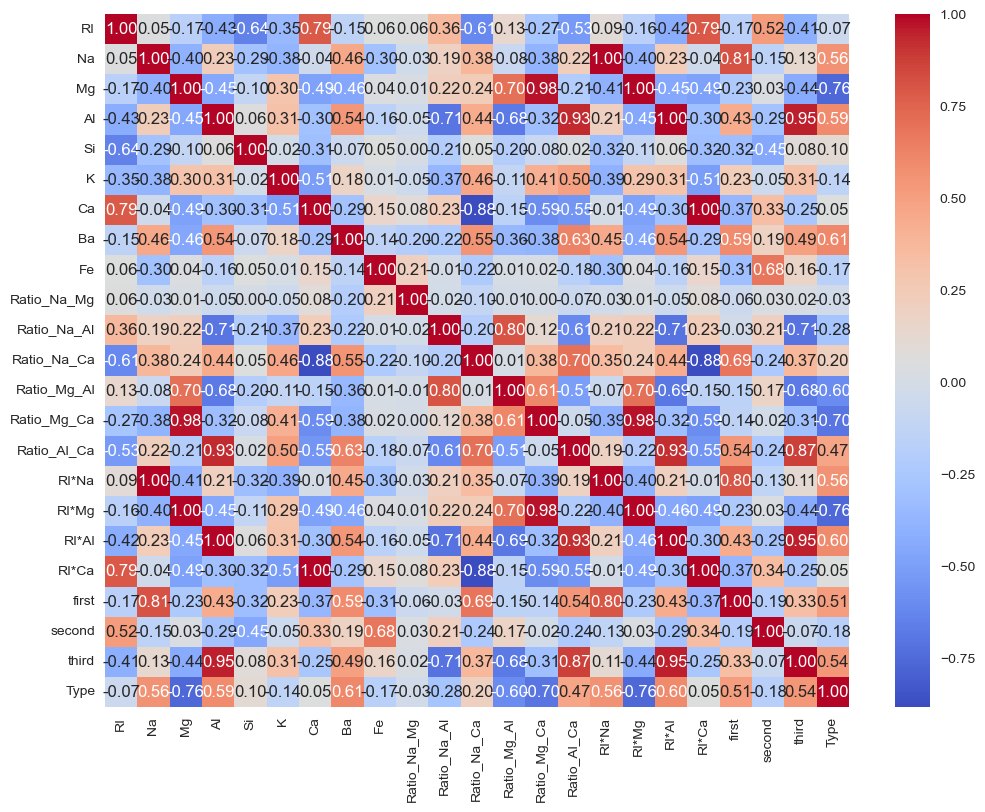

In [20]:
train_check = pd.concat([train_features, train_objective], axis=1)
# 相関行列を計算
correlation_matrix = train_check.corr()

# ヒートマップを描画
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# プロットを表示
plt.show()

In [107]:
exp = setup(train_check,
           target='Type',
           session_id=123,
           train_size=0.8,
           log_experiment=True,
           use_gpu=True,
           fold=5,
           )

,Description,Value
0,Session id,123
1,Target,Type
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 5: 3, 6: 4, 7: 5"
4,Original data shape,"(107, 23)"
5,Transformed data shape,"(107, 23)"
6,Transformed train set shape,"(85, 23)"
7,Transformed test set shape,"(22, 23)"
8,Numeric features,22
9,Preprocess,True


In [108]:
best_model = compare_models()
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7294,0.3300,0.7294,0.6929,0.6984,0.5988,0.6113,1.3720
lr,Logistic Regression,0.6941,0.3055,0.6941,0.6709,0.6646,0.5402,0.5582,0.1060
knn,K Neighbors Classifier,0.6824,0.3179,0.6824,0.6100,0.6296,0.5081,0.5282,0.1140
svm,SVM - Linear Kernel,0.6353,0.0000,0.6353,0.6489,0.6227,0.4729,0.4873,0.0880
ridge,Ridge Classifier,0.6235,0.0000,0.6235,0.5597,0.5668,0.4066,0.4358,0.0860
dt,Decision Tree Classifier,0.6118,0.2613,0.6118,0.6381,0.6121,0.4519,0.4607,0.0940
gbc,Gradient Boosting Classifier,0.6118,0.2979,0.6118,0.5849,0.5876,0.4392,0.4460,0.8960
lda,Linear Discriminant Analysis,0.6118,0.3324,0.6118,0.6838,0.6240,0.4534,0.4646,0.1160
nb,Naive Bayes,0.5765,0.3203,0.5765,0.5618,0.5389,0.3905,0.4135,0.0960
ada,Ada Boost Classifier,0.5059,0.2629,0.5059,0.3604,0.4099,0.2072,0.2532,0.1760


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [109]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7059,0.0000,0.7059,0.6667,0.6824,0.5596,0.5625
1,0.7647,0.0000,0.7647,0.7294,0.7320,0.6243,0.6374
2,0.7059,0.0000,0.7059,0.7333,0.7028,0.5596,0.5721
3,0.7647,0.8922,0.7647,0.7034,0.7195,0.6634,0.6850
4,0.7059,0.7576,0.7059,0.6317,0.6554,0.5874,0.5993
Mean,0.7294,0.3300,0.7294,0.6929,0.6984,0.5988,0.6113
Std,0.0288,0.4063,0.0288,0.0388,0.0272,0.0401,0.0451


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [110]:
pred = lgbm.predict(test_features)

for i in range(len(pred)):
    if pred[i]<=2:
        pred[i] += 1
    else:
        pred[i] += 2

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_objective, test_size=0.2, stratify = train_objective, random_state=3)

0.8352941176470589
0.6818181818181818


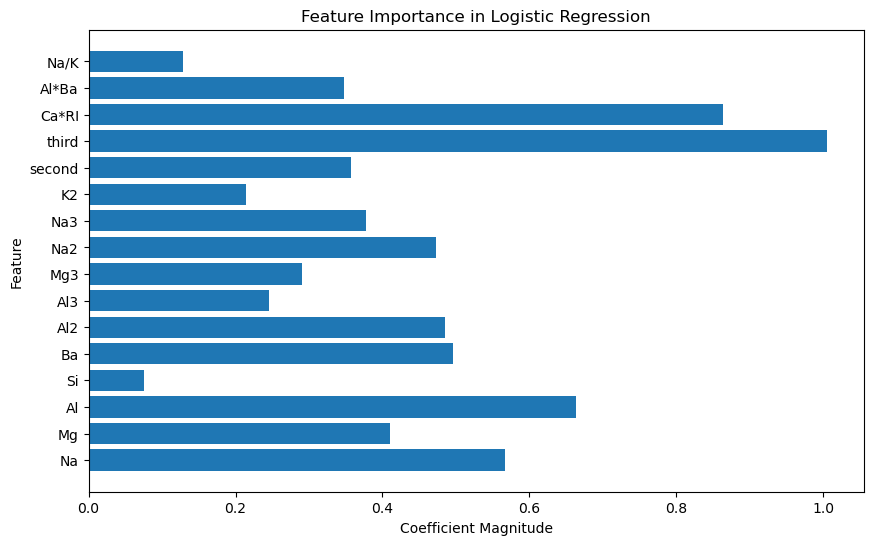

In [196]:
LR = LogisticRegression()
scoring = 'accuracy'
params = {
    "penalty": ['l1', 'l2'],
    "solver": ['liblinear'],
    'C': [10**i for i in range(-2, 2)],
    'max_iter': [i for i in range(2000, 2500)]
    }
model = GridSearchCV(
        LR,
        params,
        scoring=scoring,
        cv=3,
        )

model.fit(X_train, y_train)
y_pred1 = model.predict(X_train)
y_pred2 = model.predict(X_test)
acc_lr_tr = accuracy_score(y_train, y_pred1)
acc_lr_te = accuracy_score(y_test, y_pred2)
print(acc_lr_tr)
print(acc_lr_te)

# 特徴量の名前
feature_names = X_train.columns

# 係数を取得
coefficients = model.best_estimator_.coef_[0]

# 係数の絶対値を可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_names, np.abs(coefficients))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [23]:
train_features = train_features.drop({'K', 'RI', 'Fe', 'Ca'}, axis=1)
test_features = test_features.drop({'K', 'RI', 'Fe', 'Ca'}, axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_objective, test_size=0.2, stratify = train_objective, random_state=42)

In [23]:
LGB = lgb.LGBMClassifier()
scoring = 'accuracy'
params = {
    "n_estimators": [i for i in range(20, 60)],
    "num_leaves": [5, 10, 15, 20],
    "reg_alpha": [10**i for i in range(-2, 2)],
    "reg_lambda": [10**i for i in range(-2, 2)],
    "boosting_type": ['gbdt']
    }
model1 = GridSearchCV(
        LGB,
        params,
        scoring=scoring,
        cv=3,
        )

model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_train)
y_pred2 = model1.predict(X_test)
acc_lgbm_tr = accuracy_score(y_train, y_pred1)
acc_lgbm_te = accuracy_score(y_test, y_pred2)
print(acc_lgbm_tr)
print(acc_lgbm_te)
print(model1.best_params_)

0.8117647058823529
0.6363636363636364
{'boosting_type': 'gbdt', 'n_estimators': 20, 'num_leaves': 5, 'reg_alpha': 1, 'reg_lambda': 0.01}


In [194]:
model2 = LinearSVC()
scoring = 'accuracy'
model2.fit(X_train, y_train)
y_pred1 = model2.predict(X_train)
y_pred2 = model2.predict(X_test)
acc_svc_tr = accuracy_score(y_train, y_pred1)
acc_svc_te = accuracy_score(y_test, y_pred2)
print(acc_svc_tr)
print(acc_svc_te)

0.8117647058823529
0.6363636363636364


In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l2
# ニューラルネットワークのモデルを構築
model = Sequential()

model.add(Dense(32, activation='relu',input_shape=(18,),  kernel_regularizer=l2(0.1)))  # 入力層（L2正則化を適用）
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(6, activation='softmax'))  # 出力層

# モデルのコンパイル
model.compile(loss='categorical_crossentropy', optimizer='adam')

# モデルの学習
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2)
y_pred_all1 = model.predict(X_train)
y_pred_all2 = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_all1)
acc_test = accuracy_score(y_test, y_pred_all2)

print('Train:', acc_train)
print('Test:', acc_test)

Epoch 1/20
2/2 [==============================] - 1s 207ms/step - loss: 40.2383 - val_loss: 41.6169
Epoch 2/20
2/2 [==============================] - 0s 30ms/step - loss: 38.6795 - val_loss: 32.6839
Epoch 3/20
2/2 [==============================] - 0s 31ms/step - loss: 36.5736 - val_loss: 31.5800
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 34.9203 - val_loss: 31.1368
Epoch 5/20
2/2 [==============================] - 0s 29ms/step - loss: 31.4773 - val_loss: 30.5267
Epoch 6/20
2/2 [==============================] - 0s 30ms/step - loss: 30.2229 - val_loss: 29.3729
Epoch 7/20
2/2 [==============================] - 0s 30ms/step - loss: 28.6027 - val_loss: 28.3823
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 27.5104 - val_loss: 23.0689
Epoch 9/20
2/2 [==============================] - 0s 36ms/step - loss: 24.8072 - val_loss: 21.5959
Epoch 10/20
2/2 [==============================] - 0s 27ms/step - loss: 22.7409 - val_loss: 21.0024
Epoch 11

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [198]:
pred = model1.predict(test_features)

out_put_file = os.path.join('submission.csv')
write_submission(Id, pred, out_put_file)

In [111]:
out_put_file = os.path.join('submission.csv')
write_submission(Id, pred, out_put_file)